In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm,colors
import seaborn as sns
from myutils.utils import *

In [2]:
import folium
from branca.element import Figure
import IPython.display as display
from PIL import Image
WINNIPEG = [49.88366050119829, -97.14581222292078]

In [3]:
LANE_CLOSURE = import_data("LANE_CLOSURE")
LANE_CLOSURE

,Street,At,Boundaries,Direction,Date Closed - From,Date Closed - To,Time Closed - From,Time Closed - To,Complete Closure,Lat,Long,Geometry,Num_Segments,Num_Points
0,Bryce,River,"[River Av, End]","[Eastbound, Westbound]",2021-08-16,2021-10-16,12:00 AM,12:00 AM,No,49.879699,-97.142781,"[[(49.879153816388, -97.142387643857), (49.880...",1,3
1,Lilac,Carter,"[Carter Av, Weatherdon Av]",[Southbound],2021-06-14,2021-10-29,12:00 AM,12:00 AM,No,49.862454,-97.151445,"[[(49.862119196838, -97.151173092203), (49.862...",1,5
2,Princess,Pacific,"[Pacific Av, Rupert Av]",[Southbound],2020-08-14,2021-10-16,12:00 AM,12:00 AM,No,49.901786,-97.139766,"[[(49.90158994935, -97.139915854251), (49.9019...",1,3
3,Henry,Austin,"[Austin St, End]",[Westbound],2021-05-10,2021-11-30,12:00 AM,11:00 PM,No,49.903340,-97.134152,"[[(49.903503694415, -97.13466284795), (49.9033...",1,4
4,Grandin,Tache,"[Tache Av, St Joseph St]",[Eastbound],2021-05-31,2022-01-13,12:00 AM,12:00 AM,No,49.896013,-97.126315,"[[(49.895678857718, -97.127616387474), (49.896...",1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,Sherbrook,Logan,"[Logan Av, William Av]",[Southbound],2021-09-20,2021-11-01,12:00 AM,12:00 AM,No,49.906584,-97.153705,"[[(49.904179261579, -97.155653416614), (49.904...",1,30
426,Gull Lake,Markham,"[Markham Rd, East Lake Dr]","[Northbound, Southbound]",2021-09-17,2021-10-08,12:00 AM,12:00 AM,No,49.809311,-97.158976,"[[(49.80730904568, -97.158914003228), (49.8081...",1,39
427,Wardlaw,Osborne,"[Osborne St, Scott St]",[Eastbound],2021-09-20,2021-10-15,12:00 AM,12:00 AM,No,49.877534,-97.142232,"[[(49.876961712509, -97.143938755153), (49.877...",1,5
428,Scotsborough,Beckinsale,"[Beckinsale By, Novavista Dr]",[Southbound],2021-09-23,2021-10-13,12:00 AM,12:00 AM,No,49.820905,-97.107388,"[[(49.820524519173, -97.107184511392), (49.820...",1,4


In [4]:
STOPS = import_data("STOPS")
STOPS

,Stop Number,Stop Name,Lat,Long,Direction,Street,At
0,10001,Southbound Osborne at Mulvey,49.871261,-97.139518,Southbound,Osborne,Mulvey
1,10002,Southbound Osborne at Woodward,49.868819,-97.137553,Southbound,Osborne,Woodward
2,10003,Southbound Osborne at Brandon,49.867880,-97.136795,Southbound,Osborne,Brandon
3,10004,Southbound Osborne at Hethrington,49.866522,-97.135707,Southbound,Osborne,Hethrington
4,10005,Southbound Osborne at Morley,49.865164,-97.134604,Southbound,Osborne,Morley
...,...,...,...,...,...,...,...
5151,62018,Eastbound Parker at Beaumont,49.847806,-97.164596,Eastbound,Parker,Beaumont
5152,62021,Northbound Eaglewood at Longspur,49.780139,-97.196271,Northbound,Eaglewood,Longspur
5153,62022,Southbound Eaglewood at Longspur,49.780498,-97.196785,Southbound,Eaglewood,Longspur
5154,62023,Westbound Bison at Appleford,49.791002,-97.209359,Westbound,Bison,Appleford


In [5]:
SITES = import_data("SITES")
SITES

,Site,Street,Near,Lat,Long
0,McPhillips And 190m South Of Leila,McPhillips,Leila,49.951733,-97.149032
1,Henderson And 55M S Of Frasers Grove,Henderson,Grove,49.934985,-97.096166
2,Pembina And 280 N Of Adamar,Pembina,Adamar,49.826952,-97.152312
3,Inkster And 130W Of Wyatt,Inkster,Wyatt,49.945949,-97.187758
4,Nichol And St.Marys,Nichol,St.Marys,49.850579,-97.112202
5,Lagimodiere And 80M N Of Burmac,Lagimodiere,Burmac,49.848695,-97.049665
6,Disraeli Bridge,Disraeli,Bridge,49.906744,-97.123028
7,Marion And 260M E Of Dupuy,Marion,Dupuy,49.881900,-97.089342


In [6]:
# fig=Figure(height=1050,width=1250)
# m=folium.Map(location=WINNIPEG,tiles='cartodbpositron',zoom_start=12)
# fig.add_child(m)

# # Plotting Traffic count sites
# f1=folium.FeatureGroup("Traffic Count Sites")
# for i in SITES.index:
#     site = SITES.loc[i]
#     folium.Marker(location=list(site[["Lat","Long"]]),tooltip=f'{site["Street"]}',popup=f"{site['Site']}",icon=folium.Icon(color="red")).add_to(f1)
# f1.add_to(m)

# # Plotting Bus stops
# f2=folium.FeatureGroup("Bus stops")
# for j in STOPS.index:
#     stop = STOPS.loc[j]
#     folium.Circle(radius=4, location=list(stop[["Lat","Long"]]),tooltip=f'{stop["Stop Number"]}',popup=f"{stop['Stop Name']}",color="#3ea6d6",fill=True).add_to(f2)
# f2.add_to(m)

# # Plotting Road closure
# color = {"Yes":"red","No":"orange"}
# f3=folium.FeatureGroup("Road closure")
# for j in LANE_CLOSURE.index:
#     lane = LANE_CLOSURE.iloc[j]
#     for i in range(len(lane["Geometry"])):
#         line_1=folium.vector_layers.PolyLine(lane["Geometry"][i],popup=f'<b>Direction:</b> {", ".join(lane["Direction"])}',tooltip=f'{lane["Street"]}',color=color[lane["Complete Closure"]],weight=4).add_to(f3)
# f3.add_to(m)
# folium.LayerControl().add_to(m)
# m

In [7]:
# display.display(Image.open('plots/overview.png'))

In [8]:
# display.display(Image.open('plots/close_up.png'))

In [9]:
ROAD_NETWORK = import_data("ROAD_NETWORK")
ROAD_NETWORK["Number of Lanes"] = ROAD_NETWORK["Number of Lanes"].fillna(0).astype(int)
ROAD_NETWORK

,Block ID,Street,Street Type,Number of Lanes,Oneway,Speed Limit,Location,Num_Points
0,1873.0,Sifton,Rd,2,0,50,"[(49.810557383041, -97.143794801994), (49.8105...",2
1,23974.0,Valde,Ave,2,0,50,"[(49.910940712709, -97.003620088172), (49.9109...",2
2,23779.0,Lagimodiere,Blvd,2,1,80,"[(49.8671557845, -97.066599484474), (49.869726...",2
3,70342.0,Sage Creek,Blvd,2,2,50,"[(49.833747499855, -97.049568380871), (49.8337...",2
4,24031.0,Point,Rd,2,0,50,"[(49.846976634414, -97.145356293446), (49.8472...",2
...,...,...,...,...,...,...,...,...
28957,17669.0,Newton,Ave,2,0,50,"[(49.943945001092, -97.11556803066), (49.94406...",21
28958,23040.0,Main,St,3,1,50,"[(49.905674025615, -97.134404708765), (49.9062...",5
28959,18560.0,Digby,Ave,2,0,50,"[(49.913833165245, -97.125132844509), (49.9138...",34
28960,24835.0,Disraeli,Fwy,3,2,60,"[(49.902763600349, -97.128799417643), (49.9028...",14


In [10]:
# - One-way values are as follows:
# 0 – The street is a two-way street
# 1 – The one-way direction is opposite the digitized direction
# 2 – The one-way direction is the same as the digitized direction

In [11]:
# cmap = cm.get_cmap("coolwarm",6)
# color=colors.rgb2hex(cmap(road["Number of Lanes"])

In [12]:
# # fig=Figure(height=1050,width=1250)
# fig=Figure(height=750,width=900)

# m=folium.Map(location=WINNIPEG,tiles='cartodbpositron',zoom_start=12)
# # folium.TileLayer('cartodbdark_matter').add_to(m)
# fig.add_child(m)

# color = {50:"grey",0:"lightblue",1:"#ffaf87",2:"#ffaf87"}
# f3=folium.FeatureGroup("Road Network")
# for j in ROAD_NETWORK.index:
#     road = ROAD_NETWORK.loc[j]
#     folium.vector_layers.PolyLine(road["Location"],popup=f'<b>Number of Lanes</b> {road["Number of Lanes"]}',tooltip=f'{road["Street"]}',color=color[road["Oneway"]],weight=3).add_to(f3)
# f3.add_to(m)
# folium.LayerControl().add_to(m)
# m

In [19]:
# display.display(Image.open('plots/road_network.jpg'))

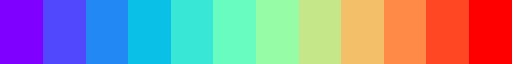

In [14]:
num_colors = 12
cmap = cm.get_cmap("rainbow",num_colors)
cmap

In [15]:
# fig=Figure(height=750,width=900)
# m=folium.Map(location=WINNIPEG,tiles='cartodbpositron',zoom_start=12)
# fig.add_child(m)

# # Plotting Traffic count sites
# f1=folium.FeatureGroup("Traffic Count Sites")
# for i in SITES.index:
#     site = SITES.loc[i]
#     folium.Marker(location=list(site[["Lat","Long"]]),tooltip=f'{site["Street"]}',popup=f"{site['Site']}",icon=folium.Icon(color="red")).add_to(f1)
# f1.add_to(m)

# # Plotting Bus stops
# f2=folium.FeatureGroup("Bus stops")
# for j in STOPS.index:
#     stop = STOPS.loc[j]
#     folium.Circle(radius=4, location=list(stop[["Lat","Long"]]),tooltip=f'{stop["Stop Number"]}',popup=f"{stop['Stop Name']}",color="#3ea6d6",fill=True).add_to(f2)
# f2.add_to(m)

# # Plotting Road closure
# color = {"Yes":"red","No":"orange"}
# f3=folium.FeatureGroup("Road closure")
# for j in LANE_CLOSURE.index:
#     lane = LANE_CLOSURE.iloc[j]
#     col=colors.rgb2hex(cmap(int(lane.name)%num_colors))
#     # folium.Marker(location=list(lane[["Lat","Long"]]),tooltip=f'{site["Street"]}',popup=f"{site['Site']}",icon=folium.Icon(color=col)).add_to(f3)
#     folium.Circle(radius=10,location=list(lane[["Lat","Long"]]),tooltip=f'{int(lane.name)}',popup=f"{col}",color=col, fill =True).add_to(f3)
#     for i in range(len(lane["Geometry"])):
#         for k in range(len(lane["Geometry"][i])):
#             folium.Circle(radius=5,location=list(lane["Geometry"][i][k]),tooltip=f'{int(lane.name)}',popup=f"{col}",color=col).add_to(f3)
#         line_1=folium.vector_layers.PolyLine(lane["Geometry"][i],popup=f'<b>Direction:</b> {", ".join(lane["Direction"])}',tooltip=f'{lane["Street"]}',color=col,weight=4).add_to(f3)
# f3.add_to(m)
# folium.LayerControl().add_to(m)
# # m.add_child(folium.LatLngPopup())
# # m.add_child(folium.ClickForMarker(popup="Waypoint"))

# m

1. Algorithms
    - Find the polygon that contains the lane closure segment(s)
    - Determine whether a point (bus stop) belongs in a polygon 
    - Polar coordinates 
    - Determine directly and indirectly affected bus stops

In [16]:
# Python 3 program to calculate Distance Between Two Points on Earth, courtesy of https://www.geeksforgeeks.org/program-distance-two-points-earth/
from math import radians, cos, sin, asin, sqrt
def distance(pt1,pt2):
    # Convert from degrees to radians.
    lat1 = radians(pt1[0])
    lon1 = radians(pt1[1])
    lat2 = radians(pt2[0])
    lon2 = radians(pt2[1])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6378100
    # calculate the result
    return(c * r)

In [17]:
s1 = tuple(SITES.iloc[0][["Lat","Long"]])
s2 = tuple(SITES.iloc[1][["Lat","Long"]])


In [18]:
distance(s1,s2)

4221.269591783586

To do: 
1. Convert from meters & angles to coordinates
2. How to know which bus stops affected by which route
    - Using Polygon. Point in Polygon
3. 

